In [20]:
import pandas as pd 
import numpy as np 
import math
from datetime import datetime
from nsepython import *
import matplotlib.pyplot as plt


In [2]:
def _get_option_variables(ticker:str):
    """args: This function take ticker in string format
       output: Option Chain Values
    """
    ticker = ticker.upper()
    ticker = 'INFY'

    # Get the option chain
    option_chain = nse_optionchain_scrapper(ticker)
    records = option_chain['records']['data']

    # Get current stock price
    S0 = option_chain['records']['underlyingValue']

    # Filter only calls (you can also choose puts)
    call_options = [item for item in records if 'CE' in item]

    # Pick the ATM (closest strike to S0)
    atm_option = min(call_options, key=lambda x: abs(x['CE']['strikePrice'] - S0))
    K = atm_option['CE']['strikePrice']
    market_price = atm_option['CE']['lastPrice']
    implied_volatility = atm_option['CE']['impliedVolatility']# decimal like 0.20
    expiry = atm_option['CE']['expiryDate']

    # Compute time to maturity in years
    expiry_date = datetime.datetime.strptime(expiry, '%d-%b-%Y')
    print("Market Price :",market_price)
    print("Implied Volatility :",implied_volatility)
    print("Expiry Date :",expiry)




In [33]:
def Monte_Carlo_Simulator(N, option_price, strike_price, expiry_date, volatility, risk_free_rate, CE=True, option_type='european'):
    """
    N : number of simulation paths
    option_price : initial spot price
    strike_price : strike price of the option
    expiry_date : datetime object of expiry
    volatility : annualized volatility
    risk_free_rate : annualized risk-free rate
    CE : True for Call, False for Put
    option_type : 'european' or 'asian'
    """
    
    today = datetime.now()
    day_diff = (expiry_date - today).days
    if day_diff <= 0:
        raise ValueError("Expiry date must be in the future")
    
    num_of_steps = day_diff
    T = day_diff / 365  # in years
    dt = T / num_of_steps
    r = risk_free_rate

    # Simulate price paths
    simulations = np.zeros((num_of_steps + 1, N))
    simulations[0] = option_price

    for t in range(1, num_of_steps + 1):
        Z = np.random.standard_normal(N)
        simulations[t] = simulations[t - 1] * np.exp((r - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * Z)

    # Determine price for payoff based on option type
    if option_type.lower() == 'european':
        S_use = simulations[-1]  # terminal price
    elif option_type.lower() == 'asian':
        S_use = np.mean(simulations, axis=0)  # average over all steps
    else:
        raise ValueError("option_type must be 'european' or 'asian'")

    # Compute payoff
    if CE:  # Call
        payoff = np.maximum(S_use - strike_price, 0)
    else:  # Put
        payoff = np.maximum(strike_price - S_use, 0)

    # Discount to present
    option_price_estimate = np.exp(-r * T) * np.mean(payoff)
    
    return option_price_estimate

In [34]:
import numpy as np
from datetime import datetime
import datetime as dt

# --- Fetch option chain (your function) ---
ticker = 'TCS'
option_chain = nse_optionchain_scrapper(ticker)
records = option_chain['records']['data']

# --- Get current stock price ---
S0 = option_chain['records']['underlyingValue']

# --- Filter only calls (or puts) ---
call_options = [item for item in records if 'CE' in item]

# --- Pick ATM option (closest strike to S0) ---
atm_option = min(call_options, key=lambda x: abs(x['CE']['strikePrice'] - S0))
K = atm_option['CE']['strikePrice']
market_price = atm_option['CE']['lastPrice']
implied_volatility = atm_option['CE']['impliedVolatility'] / 100  # convert to fraction
expiry = atm_option['CE']['expiryDate']

# --- Convert expiry to datetime object ---
expiry_date = dt.datetime.strptime(expiry, '%d-%b-%Y')

# --- Compute Monte Carlo price ---
N_simulations = 100000
CE = True  # True for Call, False for Put
option_type = 'european'

mc_price = Monte_Carlo_Simulator(N=N_simulations,
                                 option_price=S0,
                                 strike_price=K,
                                 expiry_date=expiry_date,
                                 volatility=implied_volatility,
                                 risk_free_rate=0.0625 , ##current tbill yield,
                                 CE=CE,
                                 option_type=option_type)


# --- Print results ---
print(f"Stock Price: ₹{S0}")
print(f"Strike Price: ₹{K}")
print(f"Expiry Date: {expiry}")
print(f"Market Price: ₹{market_price}")
print(f"Monte Carlo Price ({option_type.capitalize()} Option): ₹{mc_price:.2f}")


Stock Price: ₹2903
Strike Price: ₹2900
Expiry Date: 28-Oct-2025
Market Price: ₹74.85
Monte Carlo Price (European Option): ₹69.53


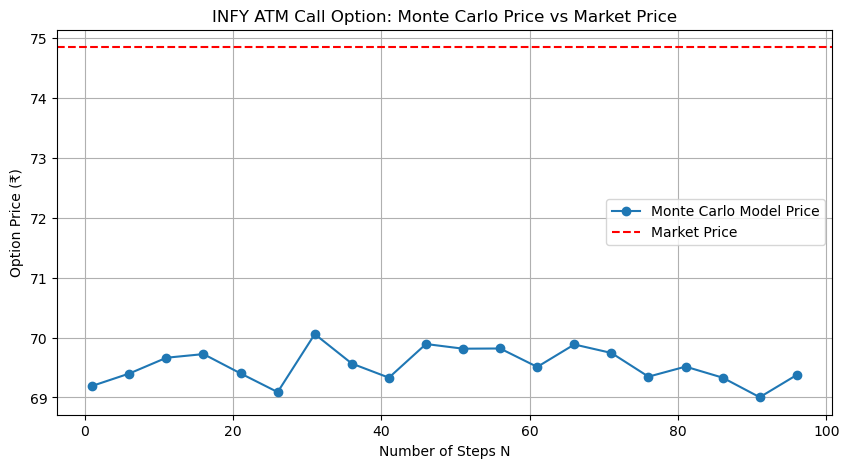

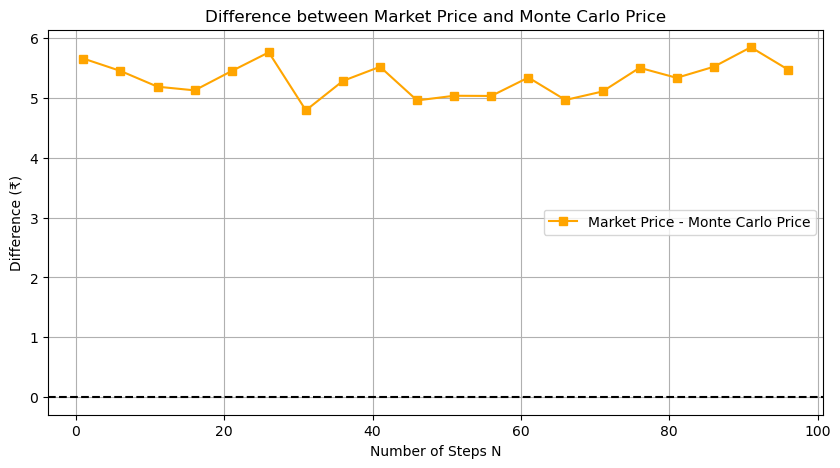

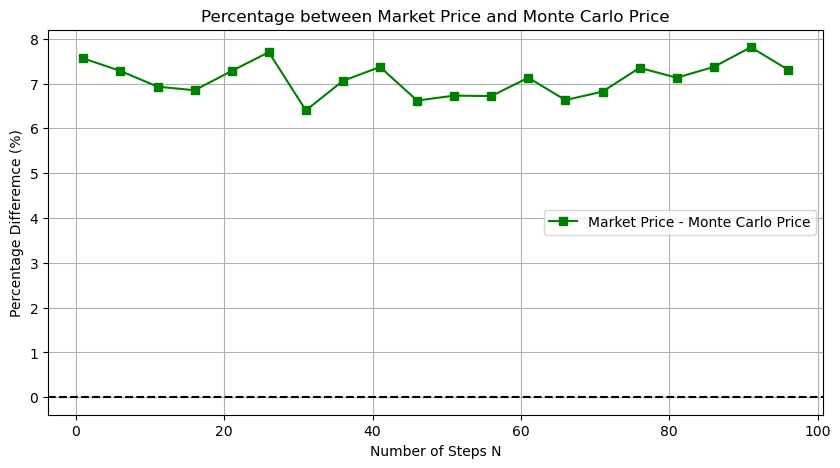

In [35]:

# List of N values to test
N_list = range(1,100,5)
monter_carlo_prices = []
differences = []
per_diff = []
# Compute Monte Carlo price for each N and difference from market
for N in N_list:
    price = Monte_Carlo_Simulator(N=N_simulations,
                                 option_price=S0,
                                 strike_price=K,
                                 expiry_date=expiry_date,
                                 volatility=implied_volatility,
                                 risk_free_rate=0.0625,  ##current tbill yield,
                                 CE=CE,
                                 option_type=option_type)
    monter_carlo_prices.append(price)
    differences.append(market_price - price)  # real difference, can be negative
    per_diff.append(np.round(abs(price - market_price)*100/market_price,2))

# Plot Monte Carlo price vs N
plt.figure(figsize=(10,5))
plt.plot(N_list, monter_carlo_prices, marker='o', label='Monte Carlo Model Price')
plt.axhline(y=market_price, color='r', linestyle='--', label='Market Price')
plt.xlabel('Number of Steps N')
plt.ylabel('Option Price (₹)')
plt.title('INFY ATM Call Option: Monte Carlo Price vs Market Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot difference from market
plt.figure(figsize=(10,5))
plt.plot(N_list, differences, marker='s', color='orange', label='Market Price - Monte Carlo Price')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Number of Steps N')
plt.ylabel('Difference (₹)')
plt.title('Difference between Market Price and Monte Carlo Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot difference from market
plt.figure(figsize=(10,5))
plt.plot(N_list, per_diff, marker='s', color='Green', label='Market Price - Monte Carlo Price')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Number of Steps N')
plt.ylabel('Percentage Differemce (%)')
plt.title('Percentage between Market Price and Monte Carlo Price')
plt.grid(True)
plt.legend()
plt.show()

